# Saving and Loading Models -- 保存和加载模型

在本笔记本中，我将向您展示如何使用PyTorch保存和加载模型。 这很重要，因为有时候我们想要先训练一个模型然后再come back加载先前训练过的模型(trained models)以用于进行预测或继续训练新数据(continue training on new data)，在本科我们学习：
+ how to save the train models 
+ how to load them (回来使用这个模型预测)

## (一)调用所需模块
+ `import fc_model` 这里系统内置(编写了)一个名为 `fc_model`的全连接我分类模型(扩展，如何在jupyter中调用自己编写的模块)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import matplotlib.pyplot as plt 

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model   #

## (二)加载数据集(dataset)
+ F_MNIST_DATA

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.
+ 作为示例，查看其中一幅图片：28x28 gray_scale

torch.Size([64, 1, 28, 28])


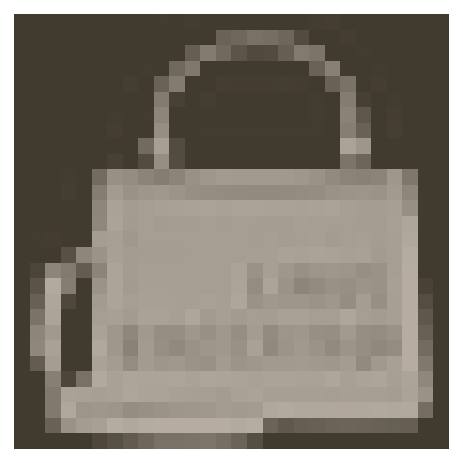

In [3]:
image, label = next(iter(trainloader))
print(image.shape)
helper.imshow(image[0,:]);

## (三)训练神经网络
在导入所需库，并加载数据集之后，我们可以开始训练数据集了。(为了使内容更简洁，课程导入了一个名为`fc_model`的模型架构和训练代码存放在名为fc_model的文件中)
+ 导入后，我们可以轻松地使用 `fc_model.Network` 创建一个全连接的网络，并使用`fc_model.train`训练这个网络
+ 然后使用这个模型(训练之后)来演示如何保存和加载模型   

```python
model = fc_model.Network(784, 10, [512, 256, 128])
```   
+ [查看fc_model的源代码] 我们创建一个全连接神经网络模型，它的结构是：784 input units, 10 output units
  + 第三个参数`[]`表示隐藏层：3个隐藏层器节点分别为 512， 256， 128
  + 输出层由 `logsoft_max` 激活，这样就能使用**负对数似然损失** `nn.NLLLoss`([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss))
  + 最后我们使用 Adam optimizer 来训练我们的神经网络及更新参数   
  
调用`fc_model`的训练函数   
```python
fc_model.train(model, trainloader, testloader, criterion, optimizer, epoch=2)
```   
+ 并不知道内部结构，根据输出可以推测是对每一个batch都打印输出！(1个epoch打印23个输出？)

In [4]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.750..  Test Loss: 0.957..  Test Accuracy: 0.683
Epoch: 1/2..  Training Loss: 0.985..  Test Loss: 0.735..  Test Accuracy: 0.706
Epoch: 1/2..  Training Loss: 0.859..  Test Loss: 0.681..  Test Accuracy: 0.737
Epoch: 1/2..  Training Loss: 0.848..  Test Loss: 0.661..  Test Accuracy: 0.749
Epoch: 1/2..  Training Loss: 0.701..  Test Loss: 0.640..  Test Accuracy: 0.760
Epoch: 1/2..  Training Loss: 0.712..  Test Loss: 0.607..  Test Accuracy: 0.771
Epoch: 1/2..  Training Loss: 0.637..  Test Loss: 0.601..  Test Accuracy: 0.780
Epoch: 1/2..  Training Loss: 0.697..  Test Loss: 0.557..  Test Accuracy: 0.790
Epoch: 1/2..  Training Loss: 0.658..  Test Loss: 0.558..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.666..  Test Loss: 0.537..  Test Accuracy: 0.806
Epoch: 1/2..  Training Loss: 0.656..  Test Loss: 0.536..  Test Accuracy: 0.804
Epoch: 1/2..  Training Loss: 0.624..  Test Loss: 0.529..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.617..  Test Loss: 0.5

+ 现在我们有了一个已经训练过的神经网络，接下来让我么学习如何**保存及再加载训练过的模型**

## (四)保存训练过的神经网络
可以想象，如果每次都在需要使用网络时才去训练网络都是不切实际的，我们可以保存经过训练的网络，然后再加载它们以进行更多训练或将其用于预测。
+ save it to a file：我们保存模型的方式是实际上保存一个字典 `state_dict`
  + 我们的模型的所有参数存储在模型的 `state_dict` 中，这是一个字典文件。 
  + 所有参数是指：模型每一层的权重和偏差矩阵
  
我们先来看看刚刚训练过的**模型的结构**，以及模型的**状态字典(`state_dict`)**的键

In [6]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


通过这个状态字典的键我们可以了解当保存模型时实际上是保存了什么，这也和 `nn.Linear()` 函数有关，当我们使用`nn.Linear()`创建隐藏层的时候，同时它会字典创建权重矩阵和bias，而这些就是被保存的参数。
+ we can save those to a file and load them back to rebuild our model

## Pytorch 语法1 -- 保存神经网络参数1

+ 最简单的事情使用 `torch.save(<>, <>)` 保存模型的参数。例如，我们可以将它保存到文件 `checkpoint.pth` 中
  + 执行这个语句之后，会在当前工作目录下生成一个 `checkpoint.pth` 文件

In [7]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Pytorch 语法2 -- 加载神经网络参数1
+ 读取模型参数字典 `torch.load(<>)`
+ 向模型导入参数 `model.load_state_dict(state_dict)`
  + 若成功会返回 `<All keys matched successfully>`
  + 注意，正确加载网络参数需要model的结构与参数数量相匹配！

In [10]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [11]:
model.load_state_dict(state_dict)

<All keys matched successfully>

似乎很简单，但通常还是复杂的，因为只有当 **model architecture** 与 **checkpoint architecture** 完全相同时，才能正确加载 `state_dict`,  如果创建的model具有不同的 architecture，则会报错：
+ 但我们在刚刚save网络的状态字典时并没有save网络的结构信息，因此若没有网络结构只有网络字典我们还是不能 rebuild 这个网络

In [12]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

## Pytorch 语法3 -- 保存神经网络参数2

因此，实际上为了完全按照训练时的模型重建模型，有关 model architecture 的信息需要与 state dict 一起保存在checkpoint文件中。 为此，您需要构建一个字典，其中包含您需要完全重建模型的所有信息。

记得保存模型参数的语句是 `torch.save(<>, <>)`：
+ 第一个参数是一个字典文件，若为 `model.state_dict()` 就是模型参数字典，我们需要重新构建一个同时包含model结构信息和参数信息的字典，例如命名为`checkpoint`
  + 网络结构包含三个部分：input_size， output_size， hidden_layers(size)一个列表文件
  + 另外加上模型参数字典： `model.state_dict()`
+ 第二个参数是保存目录，例如当前工作目录

In [15]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

###  `each.out_features`
首先 each 代表的每一个隐藏层对象，即 `nn.Linear()` 所创建的，`nn.Linear()` 是用于设置网络中的全连接层的，需要注意的是全连接层的输入与输出都是二维张量，一般形状为[batch_size, size]，不同于卷积层要求输入输出是四维张量。让我们来看看PyTorch中的`nn.Linaear()`

```python
torch.nn.Linear(in_features: int, out_features: int, bias: bool = True)
```   

 + `in_features` – size of each input sample

 + `out_features` – size of each output sample
 
 + `bias` – If set to False, the layer will not learn an additive bias. Default: True

这里的关键在于使用`nn.Linear()`的对象实例调用参数 `each.out_features`得到隐藏层的units数目，例如第一层隐藏层的`in_features`是输入层的个数，`out_feature`是第一隐藏层的单元数

## Pytorch 语法4 -- 加载神经网络参数2

现在，保存的checkpoint文件具有所有必要的信息来重建训练后的模型。根据需要轻松地将(加载模型参数到模型中)设置为函数：
+ 读取字典 `checkpoint`
+ 使用`fc_model.Network(<>, <>, <[]>)` 创建一个全连接的网络
+ 使用 `model.load_state_dict()` 加载神经网络参数

In [16]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

+ 注意这个加载模型的函数必须根据实际情况编写！

In [17]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


我们创建了一个model，训练了这个model，保存了这个model，重载了参数，读取/创建了一个新的model，而这个新的model和原理保存的那个一样！